In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from sklearn.metrics import precision_score, recall_score,accuracy_score
import string
from nltk.corpus import stopwords
import html
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from google.colab import drive
from gensim.models import KeyedVectors
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv1D, MaxPooling1D, Flatten,Input,RNN,Masking,Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
drive.mount('/content/drive')
nltk.download('wordnet')
nltk.download('stopwords')

Mounted at /content/drive


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#Corpus

In [ ]:
train_data=pd.read_csv("/content/drive/MyDrive/train.csv",header=0,names=['classid','title','desc'])
test_data=pd.read_csv("/content/drive/MyDrive/test.csv",header=0,names=['classid','title','desc'])
class_name={1:"World", 2:"Sports", 3:"Business", 4:"Sci/Tech"}

In [ ]:
train_data.head()

,classid,title,desc
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
test_data.head()

,classid,title,desc
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [ ]:
train_data.shape

(120000, 3)

In [ ]:
test_data.shape

(7600, 3)

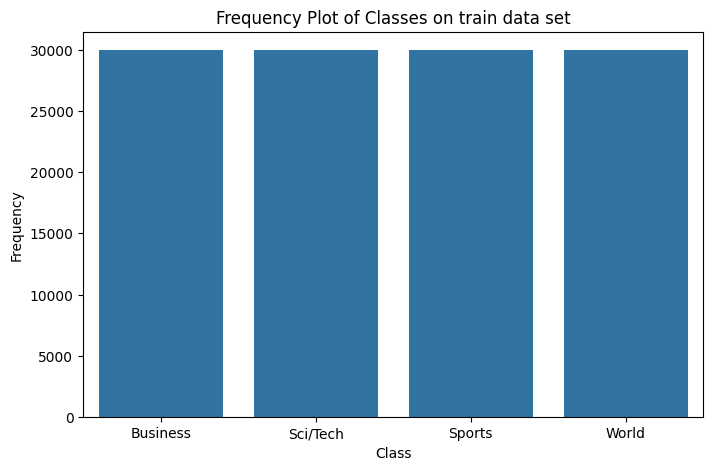

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x=[class_name[id] for id in train_data.classid])
plt.title('Frequency Plot of Classes on train data set')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

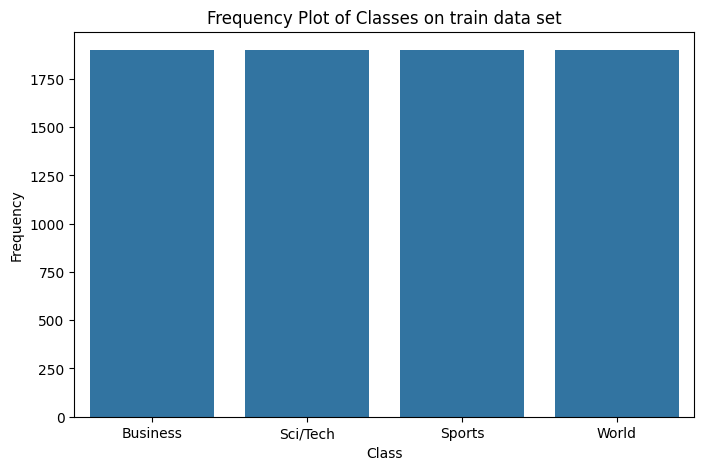

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x=[class_name[id] for id in test_data.classid])
plt.title('Frequency Plot of Classes on train data set')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [ ]:
X_train=train_data.title+train_data.desc
X_test=test_data.title+test_data.desc
y_train=train_data.classid
y_test=test_data.classid

#Important function

##Preprocess function

In [ ]:
def preprocess_text(text):
    """
    Preprocesses the input text by removing stock market tickers,
    hyperlinks, hashtags, stopwords, punctuation, and performs lemmatization.
    Handles HTML entities as well.

    Args:
    - text (str): Input text to be preprocessed.

    Returns:
    - list: A list of preprocessed and tokenized words.
    """
    # Unescape HTML entities
    text = html.unescape(text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)

    # Remove hyperlinks
    #text = re.sub(r'https?://.*[\r\n]*', '', text)
    text = re.sub(r'https?://\S+', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove hashtags (only the # sign)
    text = re.sub(r'#', '', text)

    # Lowercasing the text
    text = text.lower()

    # Tokenize the text only punctuation and character a-z pass
    tokens = re.findall(r'\b\w+\b|[.,;!?]', text)

    # Initialize a list to store the cleaned and lemmatized words
    cleaned_tokens = []
    # Initialize the WordNet Lemmatizer and English stopwords
    lemmatizer = WordNetLemmatizer()
    stopwords_english = stopwords.words('english')

    # Iterate through each word in the tokens
    for word in tokens:
        if (word not in stopwords_english and  # Remove stopwords
                word not in string.punctuation):  # Remove punctuation
            lemmatized_word = lemmatizer.lemmatize(word)  # Lemmatize the word
            cleaned_tokens.append(lemmatized_word)

    return cleaned_tokens


In [ ]:
X_preprocess_train=[preprocess_text(text) for text in X_train]
X_preprocess_test=[preprocess_text(text) for text in X_test]

In [ ]:
print(X_preprocess_test)

[['fear', 'n', 'pension', 'talksunions', 'representing', 'worker', 'turner', 'newall', 'say', 'disappointed', 'talk', 'stricken', 'parent', 'firm', 'federal', 'mogul'], ['race', 'second', 'private', 'team', 'set', 'launch', 'date', 'human', 'spaceflight', 'space', 'com', 'space', 'com', 'toronto', 'canada', 'second', 'team', 'rocketeers', 'competing', 'million', 'ansari', 'x', 'prize', 'contest', 'privately', 'funded', 'suborbital', 'space', 'flight', 'officially', 'announced', 'first', 'launch', 'date', 'manned', 'rocket'], ['ky', 'company', 'win', 'grant', 'study', 'peptide', 'ap', 'ap', 'company', 'founded', 'chemistry', 'researcher', 'university', 'louisville', 'grant', 'develop', 'method', 'producing', 'better', 'peptide', 'short', 'chain', 'amino', 'acid', 'building', 'block', 'protein'], ['prediction', 'unit', 'help', 'forecast', 'wildfire', 'ap', 'ap', 'barely', 'dawn', 'mike', 'fitzpatrick', 'start', 'shift', 'blur', 'colorful', 'map', 'figure', 'endless', 'chart', 'already', 

In [ ]:
text = '''Advanced Micro Devices Inc.'s (AMD Inc.'s) 90-nanometer notebook processors are on their way to customers, according to a research note published by Goldman Sachs   Co. Thursday.&lt;p&gt;ADVERTISEMENT&lt;/p&gt;&lt;p&gt;&lt;img src="http://ad.doubleclick.net/ad/idg.us.ifw.general/ibmpseries;sz=1x1;ord=200301151450?" width="1" height="1" border="0"/&gt;&lt;a href="http://ad.doubleclick.net/clk;9824455;9690404;u?http://ad.doubleclick.net/clk;9473681;9688522;d?http://www.ibm.com/servers/eserver/pseries/campaigns/boardroom/index.html?ca=pSeries met=boardroom me=E P_Creative=P_InfoW_RSS"&gt;Introducing IBM eServer p5 systems.&lt;/a&gt;&lt;br/&gt;Powered by IBMs most advanced 64-bit microprocessor (POWER5(tm)), p5 systems can run UNIX and Linux simultaneously. Learn more about eServer p5 systems.&lt;/p&gt;'''
text = preprocess_text(text)
print(text)

['advanced', 'micro', 'device', 'inc', 'amd', 'inc', 'nanometer', 'notebook', 'processor', 'way', 'customer', 'according', 'research', 'note', 'published', 'goldman', 'sachs', 'co', 'thursday', 'advertisementintroducing', 'ibm', 'eserver', 'p', 'system', 'powered', 'ibms', 'advanced', 'bit', 'microprocessor', 'power', 'tm', 'p', 'system', 'run', 'unix', 'linux', 'simultaneously', 'learn', 'eserver', 'p', 'system']


##Evaluation function

In [ ]:
def evaluation(y_true, y_pred, class_name, X):
    # Tính ma trận nhầm lẫn
    conf_matrix = confusion_matrix(y_true, y_pred)

    def plot_confusion_matrix(conf_matrix, class_names):
      fig, ax = plt.subplots(figsize=(8, 6))
      sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
      plt.title('Confusion Matrix')
      plt.xlabel('Predicted')
      plt.ylabel('True')
      plt.show()
    # Vẽ heatmap của ma trận nhầm lẫn
    plot_confusion_matrix(conf_matrix, class_names=list(class_name.values()))

    # In báo cáo phân loại
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, labels=list(class_name.keys()), target_names=list(class_name.values())))

    # Xác định các trường hợp sai
    errors = [(y_true[i], y_pred[i], X[i]) for i in range(len(y_true)) if y_true[i] != y_pred[i]]

    # In ra một số trường hợp sai
    print("\nSome Misclassified Examples:")
    for true_label, predicted_label, example in errors[:min(5, len(errors))]:
        print(f"True Label: {class_name[true_label]}, Predicted Label: {class_name[predicted_label]}, Example: {example}")

#BoW representation

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5)
vectorizer.fit([' '.join(tokens) for tokens in X_preprocess_train])

CountVectorizer(min_df=5)

In [ ]:
print("Number of vocabulary:", len(vectorizer.get_feature_names_out()))

Number of vocabulary: 22872


In [ ]:
X_bow_train=vectorizer.transform([' '.join(tokens) for tokens in X_preprocess_train])
X_bow_test=vectorizer.transform([' '.join(tokens) for tokens in X_preprocess_test])

In [ ]:
print(X_bow_train.shape)

(120000, 22872)


In [ ]:
print(X_bow_test.shape)

(7600, 22872)


##Naive Bayes

In [ ]:
#Initialize the Naive Bayes model
Naive_Bayes_model = MultinomialNB(alpha=0.01,fit_prior=True)
#Train the model on the training set
Naive_Bayes_model .fit(X_bow_train, y_train)

MultinomialNB(alpha=0.01)

Evaluation on test data:


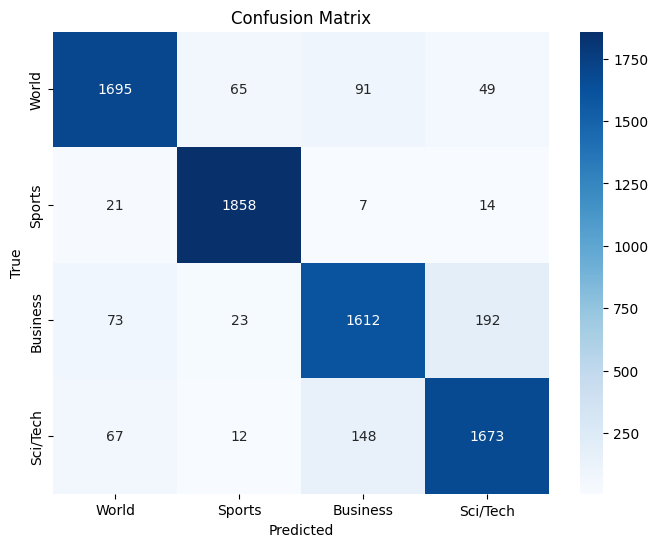


Classification Report:
              precision    recall  f1-score   support

       World       0.91      0.89      0.90      1900
      Sports       0.95      0.98      0.96      1900
    Business       0.87      0.85      0.86      1900
    Sci/Tech       0.87      0.88      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600


Some Misclassified Examples:
True Label: Sci/Tech, Predicted Label: Business, Example: Storage, servers bruise HP earningsupdate Earnings per share rise compared with a year ago, but company misses analysts' expectations by a long shot.
True Label: Sci/Tech, Predicted Label: Business, Example: Some People Not Eligible to Get in on Google IPOGoogle has billed its IPO as a way for everyday people to get in on the process, denying Wall Street the usual stranglehold it's had on IPOs. Public bidding, a minimum of just five shares, an open 

In [ ]:
y_pred_test=Naive_Bayes_model.predict(X_bow_test)
print("Evaluation on test data:")
evaluation(y_test,y_pred_test,class_name,X_test)


Nhận xét:Mô hình Naive Bayes gặp khó khăn khi phân loại tin tức khoa học/công nghệ và tin tức kinh doanh. Các dự đoán sai chủ yếu xuất phát từ sự mơ hóa giữa ngôn ngữ kinh doanh và công nghệ, cũng như sự chú ý quá mức vào tiêu đề mà bỏ qua nội dung thực sự của bài báo. Để cải thiện, cần bổ sung dữ liệu đa dạng và cải thiện khả năng hiểu biết của mô hình về nội dung bài báo, đồng thời điều chỉnh tham số mô hình.

#Word2Vec representation

In [ ]:
from gensim.models import KeyedVectors
word2vec_model  = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
print(f"Length of vector: {len(word2vec_model.get_vector('beauty'))}")
print(f"Representation of beauty: {word2vec_model.get_vector('beauty')}")

Length of vector: 300
Representation of beauty: [-0.00466919  0.24121094  0.06835938 -0.1484375   0.24902344  0.3046875
  0.07910156 -0.4765625  -0.11669922  0.19433594 -0.21875    -0.34960938
 -0.17578125  0.13183594  0.13183594  0.12890625  0.02099609  0.19824219
 -0.05395508 -0.07617188 -0.2734375  -0.14257812 -0.22265625  0.10986328
  0.16210938  0.13085938 -0.02929688  0.20996094  0.10839844 -0.3359375
 -0.31445312  0.12353516 -0.02905273  0.02307129 -0.11523438 -0.22949219
 -0.03173828 -0.24414062  0.03271484  0.04077148 -0.11230469 -0.32226562
 -0.01611328  0.09521484 -0.16601562 -0.09082031  0.18261719  0.20117188
  0.19726562  0.08056641 -0.05249023  0.18066406  0.08642578  0.265625
 -0.08105469 -0.03015137  0.01721191 -0.14160156 -0.07910156  0.10693359
  0.16308594 -0.07958984  0.23144531 -0.171875   -0.0234375  -0.01257324
 -0.265625    0.44140625  0.06396484  0.08251953  0.05371094  0.0045166
  0.02600098  0.07373047 -0.12695312  0.06030273 -0.03173828 -0.00312805
  0.0133

In [ ]:
X_word2vec_train=np.array([[word2vec_model.get_vector(token) for token in tokens if token in word2vec_model] for tokens in X_preprocess_train])
X_word2vec_test=np.array([[word2vec_model.get_vector(token) for token in tokens if token in word2vec_model] for tokens in X_preprocess_test])

<ipython-input-21-4aed75918810>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_word2vec_train=np.array([[word2vec_model.get_vector(token) for token in tokens if token in word2vec_model] for tokens in X_preprocess_train])
<ipython-input-21-4aed75918810>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_word2vec_test=np.array([[word2vec_model.get_vector(token) for token in tokens if token in word2vec_model] for tokens in X_preprocess_test])


In [ ]:
print(X_word2vec_train)

[list([array([-6.88476562e-02,  1.59179688e-01,  2.90527344e-02, -9.22851562e-02,
         2.46582031e-02, -2.51953125e-01,  1.47460938e-01, -2.40234375e-01,
         1.92382812e-01,  2.61718750e-01,  7.66601562e-02, -4.14062500e-01,
         8.34960938e-02, -1.87500000e-01, -1.65039062e-01, -1.86523438e-01,
         4.27246094e-02, -2.36511230e-03,  1.20117188e-01, -7.61718750e-02,
         2.48046875e-01,  2.47070312e-01, -7.91015625e-02, -9.81445312e-02,
         9.03320312e-03, -1.86523438e-01,  1.36718750e-01, -1.30615234e-02,
         1.48437500e-01, -3.61328125e-01, -2.01416016e-02, -1.75781250e-01,
         6.07910156e-02, -1.50756836e-02, -8.49609375e-02, -1.98242188e-01,
         1.65039062e-01,  2.91015625e-01,  1.79687500e-01, -1.49414062e-01,
         6.93359375e-02,  3.90625000e-02,  3.49609375e-01, -1.47460938e-01,
         2.41699219e-02,  3.86718750e-01, -2.38281250e-01,  4.76074219e-02,
         2.68554688e-02, -4.94384766e-03, -7.86132812e-02,  1.06445312e-01,
      

In [ ]:
X_avg_train=np.array([np.mean(X_word2vec_train[i],axis=0) for i in range(len(X_word2vec_train))])

In [ ]:
print(X_avg_train.shape)

(120000, 300)


In [ ]:
X_avg_test=np.array([np.mean(X_word2vec_test[i],axis=0) for i in range(len(X_word2vec_test))])

In [ ]:
print(X_avg_test.shape)

(7600, 300)


##Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
Logistic_Regression_model = LogisticRegression(random_state=0,max_iter=10000)

In [ ]:
Logistic_Regression_model.fit(X_avg_train,y_train)

LogisticRegression(max_iter=10000, random_state=0)

Evaluation on test data:


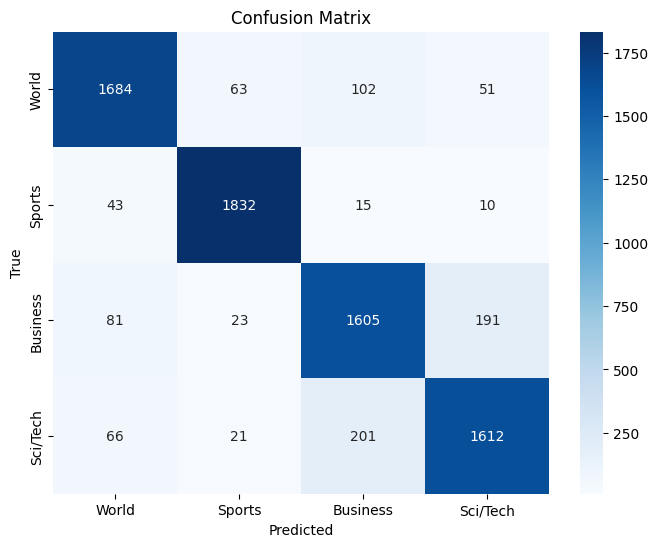


Classification Report:
              precision    recall  f1-score   support

       World       0.90      0.89      0.89      1900
      Sports       0.94      0.96      0.95      1900
    Business       0.83      0.84      0.84      1900
    Sci/Tech       0.86      0.85      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600


Some Misclassified Examples:
True Label: Sci/Tech, Predicted Label: Business, Example: Rivals Try to Turn Tables on Charles SchwabBy MICHAEL LIEDTKE     SAN FRANCISCO (AP) -- With its low prices and iconoclastic attitude, discount stock broker Charles Schwab Corp. (SCH) represented an annoying stone in Wall Street's wing-tipped shoes for decades...
True Label: World, Predicted Label: Business, Example: Venezuela Prepares for Chavez Recall VoteSupporters and rivals warn of possible fraud; government says Chavez's defeat could produce t

In [ ]:
y_pred_test=Logistic_Regression_model.predict(X_avg_test)
print("Evaluation on test data:")
evaluation(y_test,y_pred_test,class_name,X_test)

Nhận xét: Mô hình Logistic Regression đang mắc phải việc dự đoán sai với các bài báo khoa học/công nghệ, nhưng mô hình đang nhầm lẫn với tin tức kinh doanh do sự mập mờ giữa các ngữ cảnh ngôn ngữ tài chính và nội dung khoa học/công nghệ. Cải thiện có thể đạt được thông qua việc sử dụng dữ liệu đa dạng hơn và điều chỉnh mô hình để nhận biết rõ ràng hơn giữa các thể loại này.

##Multilayer perceptron

In [ ]:
MLP_model = Sequential([
    tf.keras.Input(shape=(300,)),
    Dense(units=512,kernel_regularizer=l2(0.01), activation='relu'),
    Dense(units=256, activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=4, activation='softmax')
],name='multilayer_perceptron')

In [ ]:
MLP_model.summary()

Model: "multilayer_perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               154112    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 318852 (1.22 MB)
Trainable params: 318852 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
MLP_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

In [ ]:
# Perform one-hot encoding
y_OHE_train = to_categorical(y_train-1)
y_OHE_test = to_categorical(y_test-1)

In [ ]:
history=MLP_model.fit(X_avg_train, y_OHE_train, batch_size=128, epochs=100,validation_split=0.2)

Epoch 1/100
750/750 [==============================] - 3s 4ms/step - loss: 0.3037 - accuracy: 0.9038 - val_loss: 0.3224 - val_accuracy: 0.8949
Epoch 2/100
750/750 [==============================] - 3s 4ms/step - loss: 0.3042 - accuracy: 0.9047 - val_loss: 0.3296 - val_accuracy: 0.8895
Epoch 3/100
750/750 [==============================] - 3s 4ms/step - loss: 0.3032 - accuracy: 0.9047 - val_loss: 0.3415 - val_accuracy: 0.8885
Epoch 4/100
750/750 [==============================] - 3s 4ms/step - loss: 0.3046 - accuracy: 0.9034 - val_loss: 0.3268 - val_accuracy: 0.8931
Epoch 5/100
750/750 [==============================] - 3s 4ms/step - loss: 0.3045 - accuracy: 0.9033 - val_loss: 0.3268 - val_accuracy: 0.8948
Epoch 6/100
750/750 [==============================] - 3s 4ms/step - loss: 0.3031 - accuracy: 0.9044 - val_loss: 0.3338 - val_accuracy: 0.8892
Epoch 7/100
750/750 [==============================] - 3s 4ms/step - loss: 0.3032 - accuracy: 0.9046 - val_loss: 0.3271 - val_accuracy: 0.8948

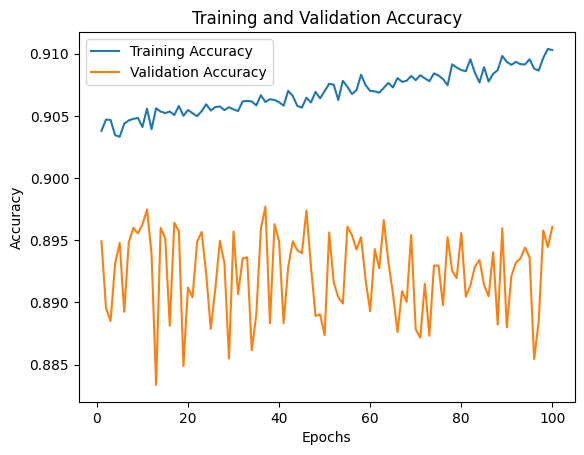

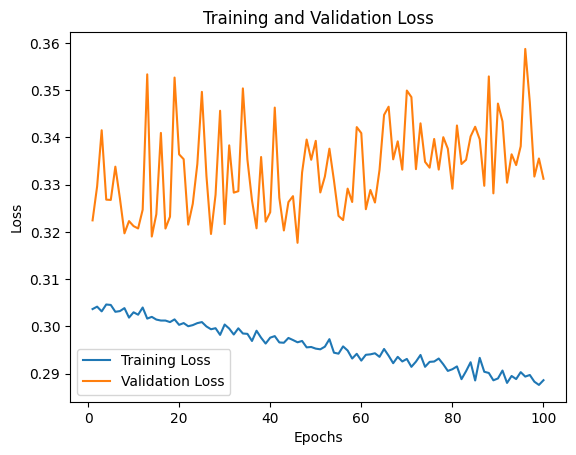

In [ ]:
# Lấy thông tin từ lịch sử
accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Vẽ biểu đồ
epochs = range(1, len(accuracy) + 1)

# Biểu đồ chính xác
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Biểu đồ mất mát
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

238/238 [==============================] - 0s 2ms/step
Evaluation on test data:


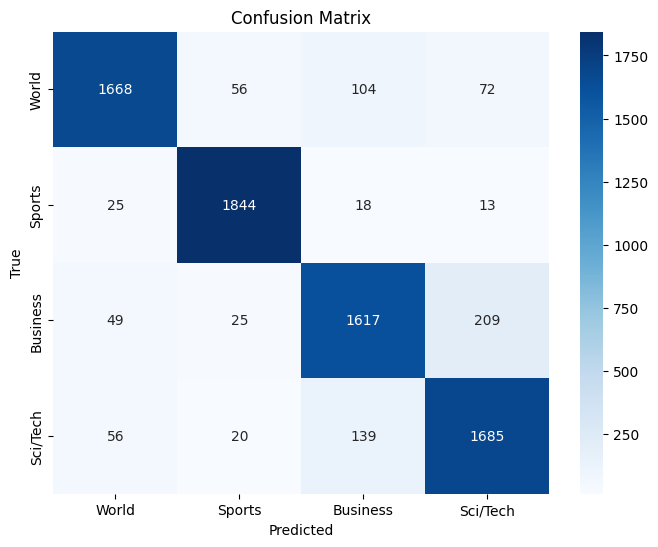


Classification Report:
              precision    recall  f1-score   support

       World       0.93      0.88      0.90      1900
      Sports       0.95      0.97      0.96      1900
    Business       0.86      0.85      0.86      1900
    Sci/Tech       0.85      0.89      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600


Some Misclassified Examples:
True Label: Sci/Tech, Predicted Label: Business, Example: Some People Not Eligible to Get in on Google IPOGoogle has billed its IPO as a way for everyday people to get in on the process, denying Wall Street the usual stranglehold it's had on IPOs. Public bidding, a minimum of just five shares, an open process with 28 underwriters - all this pointed to a new level of public participation. But this isn't the case.
True Label: Sci/Tech, Predicted Label: Business, Example: Rivals Try to Turn Tables on Charles 

In [ ]:
y_pred=np.argmax(MLP_model.predict(X_avg_test),axis=1)+1
print("Evaluation on test data:")
evaluation(y_test,y_pred,class_name,X_test)

Nhận xét: Mô hình MLP đang mắc phải việc dự đoán sai với các bài báo khoa học/công nghệ, nhưng mô hình đang nhầm lẫn với tin tức kinh doanh do sự mập mờ giữa các ngữ cảnh ngôn ngữ tài chính và nội dung khoa học/công nghệ. Cải thiện có thể đạt được thông qua việc sử dụng dữ liệu đa dạng hơn và điều chỉnh mô hình để nhận biết rõ ràng hơn giữa các thể loại này.

##Text CNN

In [ ]:
X_word2vec_train_padded=pad_sequences(X_word2vec_train, maxlen=40, padding='post', truncating='post',dtype='float32')
X_word2vec_test_padded=pad_sequences(X_word2vec_test, maxlen=40, padding='post', truncating='post',dtype='float32',)

In [ ]:
def create_textCNN_model(num_classes,learning_rate):
  model=Sequential([
      Conv1D(filters=16, kernel_size=3, activation='relu'),
      MaxPooling1D(pool_size=2),
      Flatten(),
      Dropout(rate=0.1),
      Dense(num_classes, activation='softmax')
    ]
  )
  model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
  return model

In [ ]:
def data_generator(data, batch_size):
    while True:
        batch_indices = np.random.choice(len(data[0]), batch_size, replace=False)
        batch = (data[0][batch_indices], data[1][batch_indices])
        yield batch

def training(model, batch_size, epochs, training_data, initial_checkpoint_path, final_checkpoint_path):
    if initial_checkpoint_path is not None:
        model.load_weights(initial_checkpoint_path)


    train_generator = data_generator(training_data, batch_size)

    history = model.fit(
        x=train_generator,
        steps_per_epoch=len(training_data[0]) // batch_size,
        epochs=epochs,
    )

    model.save_weights(final_checkpoint_path)

    return model, history


In [ ]:
num_classes=y_OHE_test.shape[1]
learning_rate=1e-3
textCNN=create_textCNN_model(num_classes,learning_rate)

In [ ]:
training(textCNN,512,20,(X_word2vec_train_padded,y_OHE_train),
          "/content/drive/MyDrive/training_2","/content/drive/MyDrive/training_3")

Epoch 1/20
234/234 [==============================] - 5s 23ms/step - loss: 0.2435 - categorical_accuracy: 0.9179
Epoch 2/20
234/234 [==============================] - 5s 21ms/step - loss: 0.2452 - categorical_accuracy: 0.9178
Epoch 3/20
234/234 [==============================] - 6s 25ms/step - loss: 0.2413 - categorical_accuracy: 0.9180
Epoch 4/20
234/234 [==============================] - 5s 21ms/step - loss: 0.2423 - categorical_accuracy: 0.9176
Epoch 5/20
234/234 [==============================] - 6s 24ms/step - loss: 0.2407 - categorical_accuracy: 0.9181
Epoch 6/20
234/234 [==============================] - 5s 23ms/step - loss: 0.2444 - categorical_accuracy: 0.9168
Epoch 7/20
234/234 [==============================] - 5s 21ms/step - loss: 0.2423 - categorical_accuracy: 0.9178
Epoch 8/20
234/234 [==============================] - 6s 26ms/step - loss: 0.2376 - categorical_accuracy: 0.9193
Epoch 9/20
234/234 [==============================] - 5s 22ms/step - loss: 0.2425 - categorical_

(<keras.src.engine.sequential.Sequential at 0x78a30381ec80>,
 <keras.src.callbacks.History at 0x78a303949e70>)

238/238 [==============================] - 1s 2ms/step
Evaluation on test data:


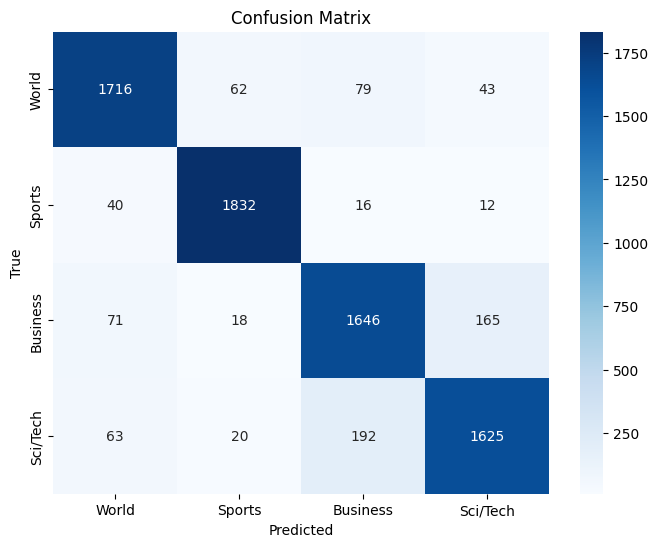


Classification Report:
              precision    recall  f1-score   support

       World       0.91      0.90      0.91      1900
      Sports       0.95      0.96      0.96      1900
    Business       0.85      0.87      0.86      1900
    Sci/Tech       0.88      0.86      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600


Some Misclassified Examples:
True Label: Sci/Tech, Predicted Label: World, Example: Prediction Unit Helps Forecast Wildfires (AP)AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning will strike in places he expects. Winds will pick up, moist places will dry and flames will roar.
True Label: Sci/Tech, Predicted Label: Business, Example: Rivals Try to Turn Tables on Charles SchwabBy MICHAEL LIEDTKE     SAN FRANCISCO 

In [ ]:
y_pred=np.argmax(textCNN.predict(X_word2vec_test_padded),axis=1)+1
print("Evaluation on test data:")
evaluation(y_test,y_pred,class_name,X_test)